# Validation of CLMUX

In [1]:
import os
import sys
sys.path.append('..')
os.chdir("..")

In [2]:
import xarray as xr
from clmux.clmux import bem
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['font.size'] = 14

coordinates=[
    ["51.525", "-0.1167"],
    ["39.9041999", "116.4073963"],
    ["22.396428", "114.109497"],
    ["40.71427", "-74.00597"],
    ["1.36666666", "103.8"]]
cities = ["london", "beijing", "hongkong", "newyork", "singapore"]

cities_labels = {
    "london": "London",
    "beijing": "Beijing",
    "hongkong": "Hong Kong",
    "newyork": "New York",
    "singapore": "Singapore"
}

Load the data

In [3]:
def get_surf_forcings(city):
    surfdata = f"data/clmu_input/surfdata_{city}.nc"
    forcingdata = f"data/hac_on/{city}/default.nc"
    surface = xr.open_dataset(surfdata)
    forcing = xr.open_dataset(forcingdata)
    forcing = forcing.assign_coords({"column": forcing.cols1d_itype_col.values})
    forcing = forcing.assign_coords({"landunit": forcing.land1d_ityplunit.values})
    forcing = forcing.assign_coords({"pft": forcing.pfts1d_itype_col.values})
    
    return surface, forcing

get building max temperature

In [4]:
def get_btmax(lat=51.525,lon=360-359.875):
    
    if lon < 0:
        lon = 360 + lon
    
    tmax = xr.open_dataset("/home/junjieyu/Github/IntelligentRoof/data/inputfolder/lnd/clm2/urbandata/CLM50_tbuildmax_Oleson_2016_0.9x1.25_simyr1849-2106_c160923.nc")
    tmax = tmax.sel(lon=lon,lat=lat,method='nearest')
    return tmax['tbuildmax_MD'].sel(time="2010").values

Create a BEM object

In [5]:
bem = bem()

get input data

In [6]:
def get_input(time_step : int,
              surface : xr.Dataset,
              forcing : xr.Dataset,
              urban_hac : str = "on",
              urban_explicit_ac : str = "on",
              p_ac : float = 1.0,
              vent_ach : float = 0.3,
              t_roof_inner_bef = 291.80765,
              t_sunw_inner_bef = 291.96564,
              t_shdw_inner_bef = 291.96564,
              t_floor_bef = 291.9698,
              t_building_bef = 290.44763,
              t_building_max = 380,
              t_building_min = 285.1000061
              ):
    dtime = 1800.0 # time step in seconds
    urban_hac = urban_hac
    urban_explicit_ac = urban_explicit_ac
    p_ac = p_ac
    ht_roof = surface['HT_ROOF'].sel(numurbl=3).isel(lsmlat=0, lsmlon=0).values
    vent_ach = vent_ach
    canyon_hwr = surface['CANYON_HWR'].sel(numurbl=3).isel(lsmlat=0, lsmlon=0).values
    wtlunit_roof = surface['WTLUNIT_ROOF'].sel(numurbl=3).isel(lsmlat=0, lsmlon=0).values
    zi_roof = surface['THICK_ROOF'].sel(numurbl=3).isel(lsmlat=0, lsmlon=0).values/10 * 0.5
    z_roof = 0

    tssbef_roof = forcing['TSOI'].sel(column=71).isel(levgrnd=9).isel(time=time_step).values
    t_soisno_roof = forcing['TSOI'].sel(column=71).isel(levgrnd=9).isel(time=time_step+1).values
    tk_roof = surface['TK_ROOF'].sel(nlevurb=9, numurbl=3).isel(lsmlat=0, lsmlon=0).values
    zi_sunw = surface['THICK_WALL'].sel(numurbl=3).isel(lsmlat=0, lsmlon=0).values/10 * 0.5
    z_sunw = 0

    tssbef_sunw = forcing['TSOI'].sel(column=72).isel(levgrnd=9).isel(time=time_step).values
    t_soisno_sunw = forcing['TSOI'].sel(column=72).isel(levgrnd=9).isel(time=time_step+1).values
    tk_sunw = surface['TK_WALL'].sel(nlevurb=9, numurbl=3).isel(lsmlat=0, lsmlon=0).values
    tk_shdw = surface['TK_WALL'].sel(nlevurb=9, numurbl=3).isel(lsmlat=0, lsmlon=0).values
    
    zi_shdw = surface['THICK_WALL'].sel(numurbl=3).isel(lsmlat=0, lsmlon=0).values/10 * 0.5
    z_shdw = 0
    
    tssbef_shdw = forcing['TSOI'].sel(column=73).isel(levgrnd=9).isel(time=time_step).values
    t_soisno_shdw = forcing['TSOI'].sel(column=73).isel(levgrnd=9).isel(time=time_step+1).values
    taf = forcing['TSA'].sel(pft=71).isel(time=time_step+1).values

    return dtime, urban_hac, urban_explicit_ac, p_ac, ht_roof, \
        t_building_max, t_building_min, vent_ach, canyon_hwr, wtlunit_roof,\
        zi_roof, z_roof, tssbef_roof, t_soisno_roof, tk_roof,\
        zi_sunw, z_sunw, tssbef_sunw, t_soisno_sunw, tk_sunw,\
        zi_shdw, z_shdw, tssbef_shdw, t_soisno_shdw, tk_shdw,\
        t_roof_inner_bef, t_sunw_inner_bef, t_shdw_inner_bef, t_floor_bef, t_building_bef, taf


define run module

In [7]:
def run(init_time_step, surface, forcing, steps, t_building_max=380):
    TBUID = []
    HEAT = []
    BUILD_FLUX = []
    TROOF_INNER = []
    TSUNW_INNER = []
    TSHDW_INNER = []
    TFLOOR = []
    time_step = init_time_step
    t_roof_inner_bef = forcing['TROOF_INNER'].sel(landunit=9).values[int(init_time_step)]
    t_sunw_inner_bef = forcing['TSUNW_INNER'].sel(landunit=9).values[int(init_time_step)]
    t_shdw_inner_bef = forcing['TSHDW_INNER'].sel(landunit=9).values[int(init_time_step)]
    t_floor_bef = forcing['TFLOOR'].sel(landunit=9).values[int(init_time_step)]
    t_building_bef = forcing['TBUILD'].sel(landunit=9).values[int(init_time_step)]
    t_building_max = t_building_max
    t_building_min = surface['T_BUILDING_MIN'].sel(numurbl=3).isel(lsmlat=0, lsmlon=0).values
    vent_ach = 0.30
    urban_hac = "on"
    urban_explicit_ac = "off"
    TBUID.append(t_building_bef)
    TROOF_INNER.append(t_roof_inner_bef)
    TSUNW_INNER.append(t_sunw_inner_bef)
    TSHDW_INNER.append(t_shdw_inner_bef)
    TFLOOR.append(t_floor_bef)
    HEAT.append(0)
    BUILD_FLUX.append(0)
    for i in range(steps):
        input = get_input(time_step = time_step,
                          urban_hac=urban_hac,
                          vent_ach=vent_ach,
                          urban_explicit_ac = urban_explicit_ac,
                          surface=surface,
                          forcing = forcing,
                          t_roof_inner_bef=t_roof_inner_bef,
                          t_sunw_inner_bef=t_sunw_inner_bef,
                          t_shdw_inner_bef=t_shdw_inner_bef,
                          t_floor_bef=t_floor_bef,
                          t_building_bef=t_building_bef,
                          t_building_max=t_building_max,
                          t_building_min=t_building_min
                        )
        #print(input)
        t_roof_inner_bef,t_sunw_inner_bef,\
        t_shdw_inner_bef,t_floor_bef,t_building_bef,\
        info = bem.bem(*input)
        TBUID.append(t_building_bef)
        TROOF_INNER.append(t_roof_inner_bef)
        TSUNW_INNER.append(t_sunw_inner_bef)
        TSHDW_INNER.append(t_shdw_inner_bef)
        TFLOOR.append(t_floor_bef)
        HEAT.append(info['eflx_urban_heat [W/m**2]'])
        BUILD_FLUX.append(info['eflx_ventilation [W/m**2]'])
        time_step += 1
        #t_roof_inner_bef = forcing['TROOF_INNER'].sel(landunit=9).values[int(time_step-1)]
        #t_sunw_inner_bef = forcing['TSUNW_INNER'].sel(landunit=9).values[int(time_step-1)]
        #t_shdw_inner_bef = forcing['TSHDW_INNER'].sel(landunit=9).values[int(time_step-1)]
        #t_building_bef = forcing['TBUILD'].sel(landunit=9).values[int(time_step-1)]
        #t_floor_bef = forcing['TFLOOR'].sel(landunit=9).values[int(time_step-1)]
        #print(info)
        #print(time_step)
        

    return TBUID,TROOF_INNER,TSUNW_INNER,TSHDW_INNER,TFLOOR, BUILD_FLUX

plotting module

In [8]:
def plotting(city, TBUID, forcing, timestep=200):
    fig, ax = plt.subplots(2,1,figsize=(10,5))
    
    cities_labels = {
    "london": "London",
    "beijing": "Beijing",
    "hongkong": "Hong Kong",
    "newyork": "New York",
    "singapore": "Singapore"}
    colors = ["#3964DF", "#E02927"]
    ax[0].plot(TBUID[0:timestep], label='Python', color=colors[0])
    ax[0].plot(forcing['TBUILD'].sel(landunit=9).values[0:timestep+1], label='HAC on', color=colors[1])
    ax[0].set_title(cities_labels[city], loc='left')
    ax[0].legend(frameon=False)
    ax[0].set_ylabel("Building temperature [K]")
    #plot difference
    diff = TBUID[0:timestep] - forcing['TBUILD'].sel(landunit=9).values[0:timestep]
    ax[1].plot(diff, color=colors[0])
    ax[1].set_ylabel("Difference [K]")
    ax[1].set_xlabel("Time step")
    
    fig.tight_layout()
    fig.savefig(f"/home/junjieyu/Github/CLMUX/clmux_val/figs/clmux_val_{city}.pdf", dpi=300)
    fig.show()

## Main function

In [9]:
def main(city, timestep=7200):
    surface, forcing = get_surf_forcings(city)
    t_building_max = get_btmax(lat=float(coordinates[cities.index(city)][0]),lon=float(coordinates[cities.index(city)][1]))
    TBUID,TROOF_INNER,TSUNW_INNER,TSHDW_INNER,TFLOOR,BUILD_FLUX = run(0,surface, forcing, timestep, t_building_max)
    plotting(city, TBUID, forcing, timestep)
    
    return TBUID,TROOF_INNER,TSUNW_INNER,TSHDW_INNER,TFLOOR,BUILD_FLUX

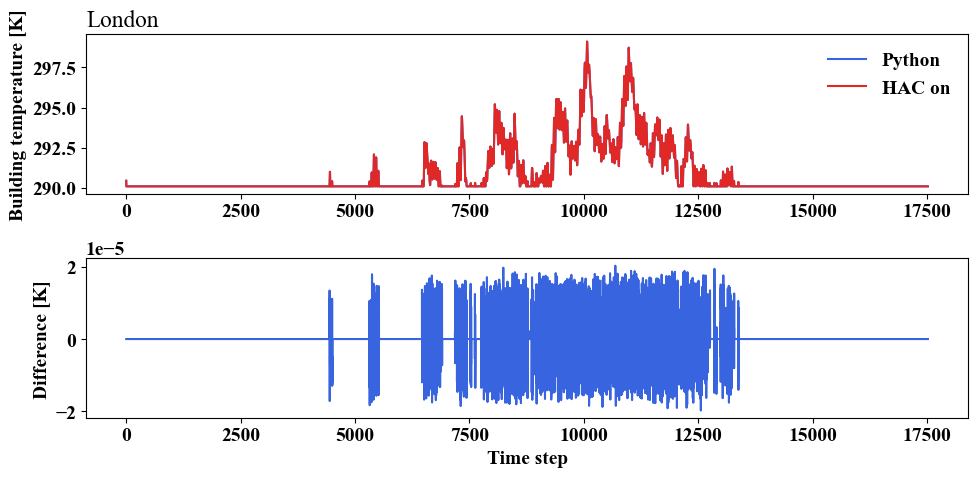

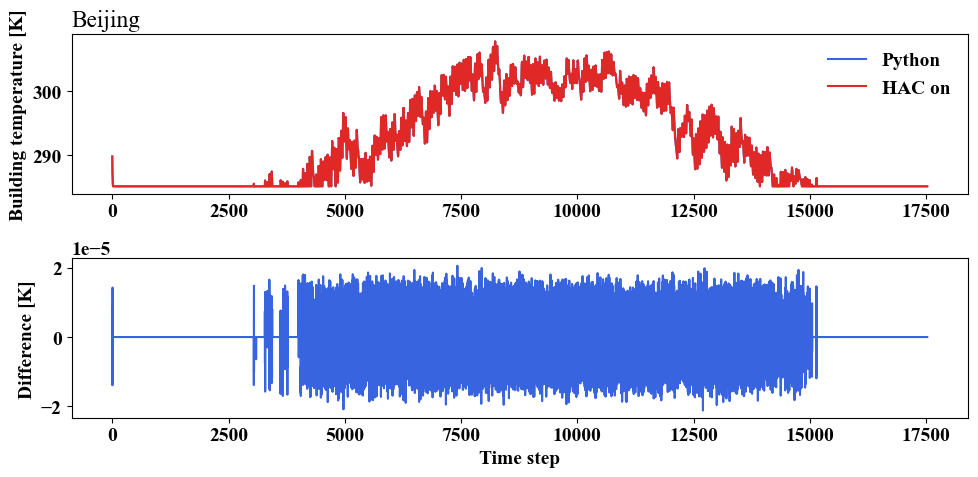

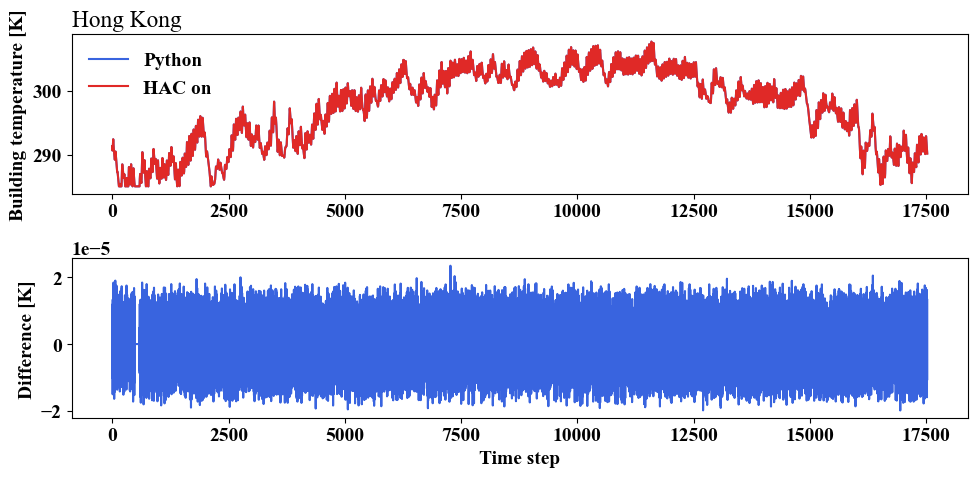

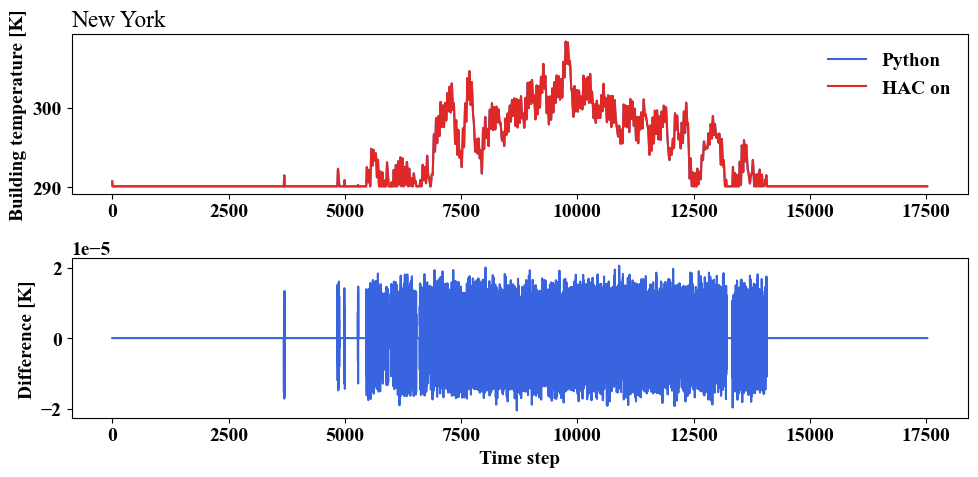

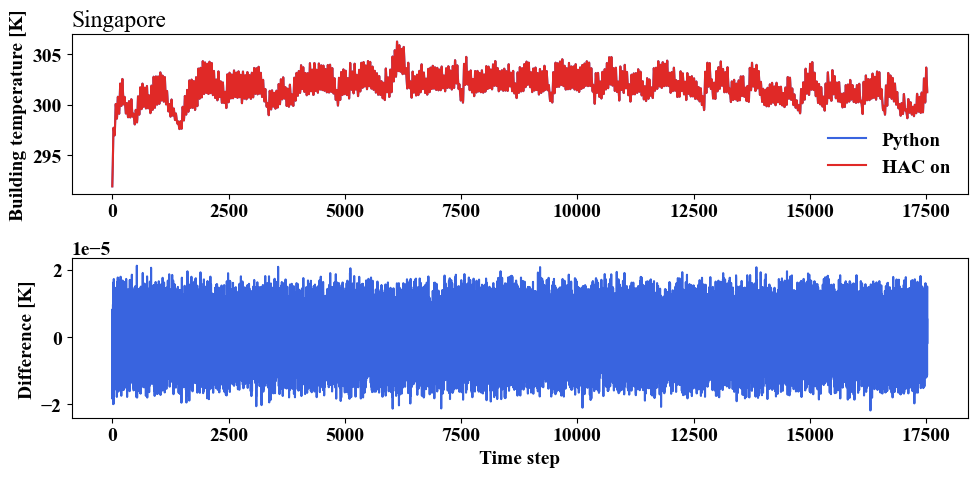

In [10]:
for city in cities:
    TBUID,TROOF_INNER,TSUNW_INNER,TSHDW_INNER,TFLOOR,BUILD_FLUX = main(city, timestep=48*365)